In [1]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [2]:
using Revise 
using RxInfer
using Random, LinearAlgebra, SpecialFunctions, Plots, StableRNGs, DomainSets,LaTeXStrings   
using Zygote, Optim, ForwardDiff
using KernelFunctions, MAT, LoopVectorization
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix 
import ReactiveMP: approximate_meancov, approximate_kernel_expectation, WishartFast, logdet

In [3]:
include("multivariateSGPnode.jl")
pgfplotsx()

Plots.PGFPlotsXBackend()

In [4]:
function predict_gp(X_test, Xu, Yu, var_Yu,C, kernel)
    Kuu = kron(C,kernelmatrix(kernel,Xu))
    K_test_u =kron(C,kernelmatrix(kernel,X_test,Xu))
    Ktest =kron(C,kernelmatrix(kernel,X_test))

    μ = K_test_u * Yu 
    Σ = Ktest - K_test_u * inv(Kuu + Diagonal(var_Yu)) * K_test_u'
    return μ, Σ
end

function  PredictState(prev_state, qv, qw , meta)
    return @call_rule GPTransition(:out, Marginalisation) (q_in = prev_state, q_v = qv, q_w = qw, meta = meta)
end
function UpdateState(prior_prediction, observation)
    likelihood_update = @call_rule MvNormalMeanCovariance(:μ, Marginalisation) (m_out = PointMass(observation), m_Σ = PointMass(P))
    x = ReactiveMP.prod(GenericProd(), prior_prediction, likelihood_update)
    return x
end

## Prediction
function predict_UT(f, qx,qw, meta)
    qz = ReactiveMP.approximate(meta, f, (qx,))
    prediction_x = @call_rule MvNormalMeanPrecision(:out, Marginalisation) (q_μ = qz, q_Λ = qw)
    return prediction_x
end


predict_UT (generic function with 1 method)

In [5]:
N = 700
max_time = 7
Δt = max_time / (N-1)

function transition_function(x_prev)
    x_1 = x_prev[1] + x_prev[2] * Δt 
    x_2 = x_prev[2] - 9.81 * sin(x_prev[1]) * Δt
    return [x_1, x_2]
end

function generate_data(n,x_init, Q, P;rng = MersenneTwister(124))
    x_prev = x_init  #initial angle and angular velocity
    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)
    for i in 1:n
        x[i] = transition_function(x_prev) + rand(rng, MvNormal(zeros(2),Q))
        y[i] = x[i] + rand(rng, MvNormal(zeros(2),P))
        x_prev = x[i]
    end
    return x, y 
end

generate_data (generic function with 1 method)

In [6]:
qc = 0.01
Q = [qc*Δt^3/3 qc*Δt^2/2;qc*Δt^2/2 qc*Δt]

P = 0.1*diageye(2) 
H = [1,0]
x_init = [1.5, 0.]

x_state, y_observation = generate_data(N,x_init, Q,P);
time_interval = collect(0:Δt:max_time)
;

In [7]:
n_train = 300
true_state_train = x_state[1:n_train]
y_train = y_observation[1:n_train]
true_state_test = x_state[1+n_train:end]
y_test = y_observation[1+n_train:end];

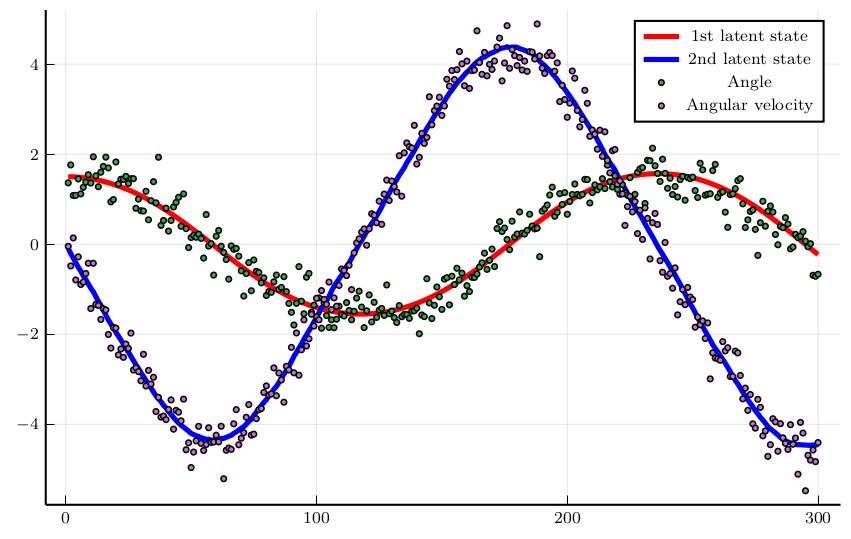

In [8]:
plot(getindex.(true_state_train,1), lw=2.5,label="1st latent state",color=:red)
plot!(getindex.(true_state_train,2), lw=2.5, label="2nd latent state",color=:blue)
scatter!(getindex.(y_train,1), markersize = 1.8, label="Angle", legend=:topright)
scatter!(getindex.(y_train,2), markersize = 1.8, label="Angular velocity")
# scatter!(time_interval, getindex.(y_observation,2), size=[800,300], markersize = 1.8, label="observation")

In [36]:
savefig("texfiles/pendulum_observation.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_observation.svg"

In [9]:

Xu_2_neg1 = reverse(collect(range(-4,0;length=12)));
Xu_2_neg2 = reverse(Xu_2_neg1) .+ 1e-5
Xu_2_pos1 = collect(range(1e-4,4;length=12));
Xu_2_pos2 = reverse(Xu_2_pos1)
Xu_2 = vcat(Xu_2_neg1,Xu_2_neg2,Xu_2_pos1,Xu_2_pos2)

Xu_1 = collect(range(-2,2;length=Int(length(Xu_2)/2)));
Xu_1 = vcat(reverse(Xu_1), Xu_1 .+ 1e-5);

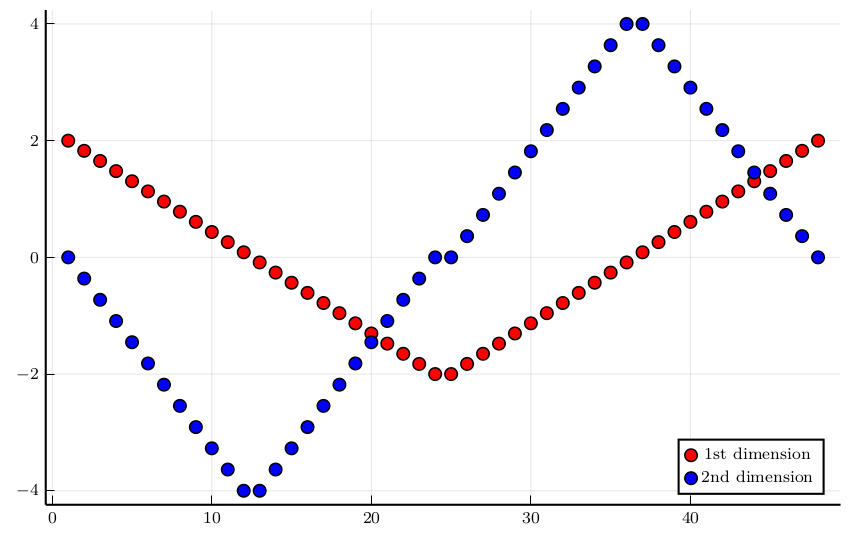

In [10]:
scatter(Xu_1,label="1st dimension", legend= :bottomright,color=:red)
scatter!(Xu_2,label="2nd dimension",color=:blue)

In [39]:
savefig("texfiles/pendulum_inducingpoint.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_inducingpoint.svg"

In [11]:
## 2-D data, fully observed
@model function pendulum_GP(y,Kuu_big,P)
    v ~ MvNormalMeanCovariance(zeros(size(Kuu_big,1)), 100*diageye(size(Kuu_big,1)))
    W ~ Wishart(1e2,diageye(2))
    x_prev ~ MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))

    for i=1:length(y)
        x[i] ~ GPTransition(x_prev,v,W)
        y[i] ~ MvNormalMeanCovariance(x[i], P)
        x_prev = x[i]
    end
end

In [31]:
Xu = [[Xu_1[i],Xu_2[i]] for i=1:length(Xu_1)]
kernel_gp = 0.1297 * with_lengthscale(Matern52Kernel(),3.43953)
meanfunc = (x) -> 0.0
Kuu = kernelmatrix(kernel_gp,Xu,Xu) + 1e-12*I;
Kuu_inverse = inv(Kuu) + 1e-12*I;
C = diageye(2)  #coregionalization matrix 
;

In [32]:
@meta function gpssm_meta(Xu,Kuu_inverse,C,kernel,cache)
    GPTransition() -> GPTransitionMeta(Xu,Kuu_inverse,C,kernel,cache)
end

gp_constraint = @constraints begin
    q(x,x_prev,v,W) = q(x)q(x_prev)q(v)q(W)
    q(x) = q(x[begin])..q(x[end])
end

gp_initialization = @initialization begin
    q(v) = MvNormalMeanCovariance(zeros(size(kron(C,Kuu),1)),100*diageye(size(kron(C,Kuu),1)))
    q(x) = MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))
    q(W) = Wishart(1e2,diageye(2))
end
;

In [33]:
niter = 30;

infer_result_gp = infer(
    model = pendulum_GP(Kuu_big = kron(C,Kuu),P = P,),
    iterations = niter,
    data = (y = y_train,),
    initialization = gp_initialization,
    meta = gpssm_meta(Xu, Kuu_inverse,C,kernel_gp,GPCache()),
    constraints = gp_constraint,
    returnvars = (x = KeepLast(), v = KeepLast(), W = KeepLast(),),
    free_energy = true,
    showprogress = true
) 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


Inference results:
  Posteriors       | available for (v, W, x)
  Free Energy:     | Real[2338.79, 1715.8, 757.23, 576.864, 511.115, 478.147, 458.84, 446.556, 438.366, 432.739  …  419.046, 418.927, 418.838, 418.776, 418.728, 418.697, 418.675, 418.658, 418.652, 418.647]


In [34]:
qv_gp = infer_result_gp.posteriors[:v]
qx_gp = infer_result_gp.posteriors[:x];
qw_gp = infer_result_gp.posteriors[:W];

## Unscented Transform (known function)

In [35]:
@model function VMPsmoothing(y,P)
    W ~ Wishart(1e2, diageye(2))
    x_prev ~ MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))

    for i=1:length(y)
        x[i] ~ MvNormalMeanPrecision(transition_function(x_prev), W)
        y[i] ~ MvNormalMeanCovariance(x[i], P)
        x_prev = x[i]
    end
end

In [20]:
meta_VMPsmoothing = @meta begin
    transition_function() -> UT()
end

ut_constraint = @constraints begin
    q(x,x_prev,W) = q(x)q(x_prev)q(W)
    q(x) = q(x[begin])..q(x[end])
end

ut_initialization = @initialization begin
    q(W) = Wishart(1e2,diageye(2))
    q(x) = MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))
end

infer_result_VMPsmoothing = infer(
    model = VMPsmoothing(P=P),
    data = (y = y_train,),
    meta = meta_VMPsmoothing,
    iterations = niter,
    constraints = ut_constraint,
    initialization = ut_initialization,
    returnvars = (x = KeepLast(), W = KeepLast(),),
    options = (limit_stack_depth=100,),
    free_energy = true
) 

qx_UT = infer_result_VMPsmoothing.posteriors[:x];
qw_UT = infer_result_VMPsmoothing.posteriors[:W]
;

## Result comparison 

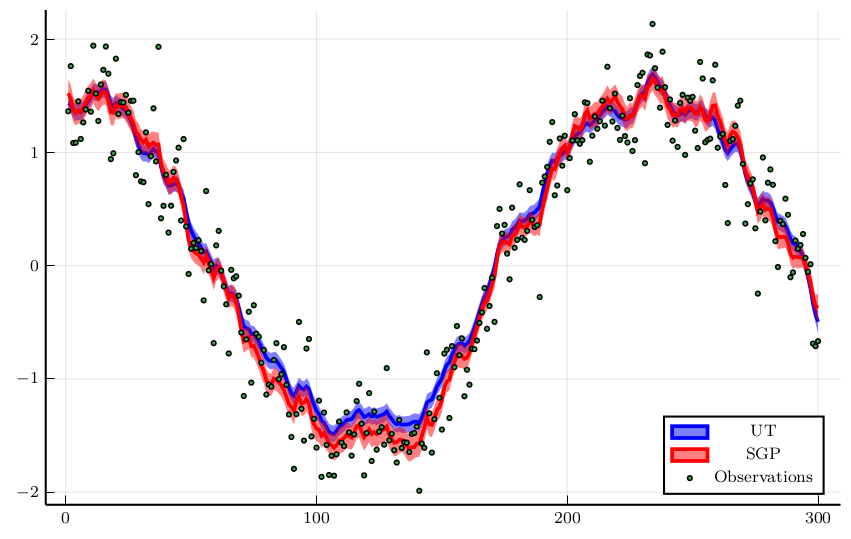

In [36]:
plot(getindex.(mean.(qx_UT),1),ribbon = sqrt.(getindex.(var.(qx_UT),1)),
    label="UT", lw = 1.8, legend=:bottomright,
    color=:blue)
plot!(getindex.(mean.(qx_gp),1),ribbon = sqrt.(getindex.(var.(qx_gp),1)),label="SGP",
     lw = 1.8,
     color=:red)
scatter!(getindex.(y_train,1), markersize=1.5, label="Observations")

In [41]:
savefig("texfiles/pendulum_1st_state.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_1st_state.svg"

In [37]:
function rmse_score(y_predict, y_true)
    return sqrt(mean((y_predict - y_true).^2))
end
rmse_UT_1st_state = rmse_score(getindex.(true_state_train,1), getindex.(mean.(qx_UT),1))
rmse_GPnode_1st_state = rmse_score(getindex.(true_state_train,1), getindex.(mean.(qx_gp),1))
println("The rmse of SGP node: $rmse_GPnode_1st_state")
println("The rmse of UT: $rmse_UT_1st_state")

The rmse of SGP node: 0.12175561152759848
The rmse of UT: 0.12946006839667704


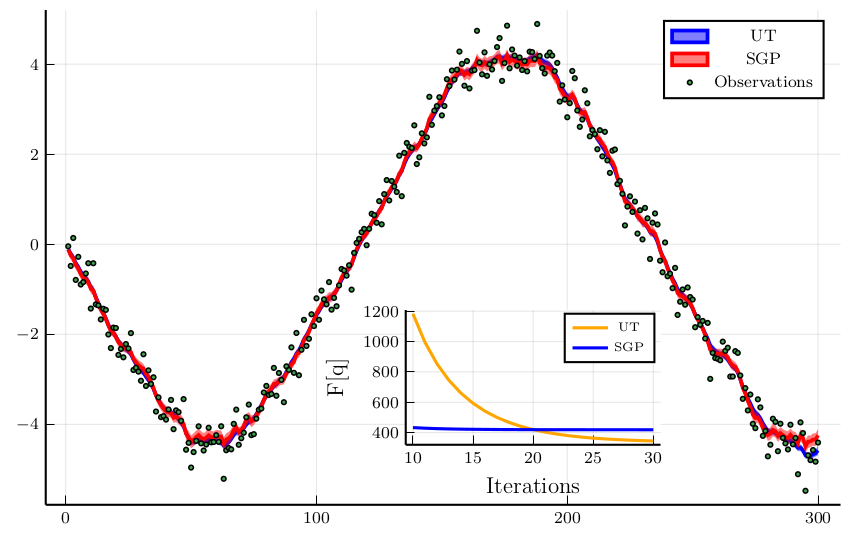

In [38]:
plot(getindex.(mean.(qx_UT),2),ribbon = sqrt.(getindex.(var.(qx_UT),2)),label="UT", 
                lw = 1.8, legend=:topright, color=:blue)
plot!(getindex.(mean.(qx_gp),2),ribbon = sqrt.(getindex.(var.(qx_gp),2)),label="SGP", 
        lw = 1.8, color=:red)
scatter!(getindex.(y_train,2), markersize=1.5, label="Observations")

plot!([collect(10:30),collect(10:30)],
    [infer_result_VMPsmoothing.free_energy[10:30], infer_result_gp.free_energy[10:30]], 
    label=["UT" "SGP"],
    color=[:orange :blue],
    lw= [1.5 1.5],
    legend=:topright,
    legend_font_pointsize=6,
    inset = (1, bbox(0.4, 0.1, 0.4, 0.4, :bottom, :left)),
    xlabel="Iterations",
    ylabel="F[q]",
    subplot = 2)

In [53]:
savefig("texfiles/pendulum_2nd_state.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_2nd_state.svg"

In [39]:
rmse_UT_2st_state = rmse_score(getindex.(true_state_train,2), getindex.(mean.(qx_UT),2))
rmse_GPnode_2st_state = rmse_score(getindex.(true_state_train,2), getindex.(mean.(qx_gp),2))
println("The rmse of SGP node: $rmse_GPnode_2st_state")
println("The rmse of UT: $rmse_UT_2st_state")

The rmse of SGP node: 0.12467435913124968
The rmse of UT: 0.10171115080632166


## One- step-ahead prediction

In [40]:
prev_state = qx_gp[end]
predicted_state = []
for i=1:length(y_test)
    prediction = PredictState(prev_state,qv_gp,qw_gp,GPTransitionMeta(Xu, Kuu_inverse,C,kernel_gp,GPCache()))
    push!(predicted_state,prediction)
    prev_state = UpdateState(prediction, y_test[i])
end

UT_predict_future = []
UT_var_predict_future = []
UT_prev_state = qx_UT[end]
for i=1:length(y_test)
    prediction = predict_UT(transition_function, UT_prev_state, qw_UT, UT())
    append!(UT_predict_future,mean(prediction)[1])
    append!(UT_var_predict_future,var(prediction)[1]) 
    UT_prev_state = UpdateState(prediction, y_test[i])
end
;

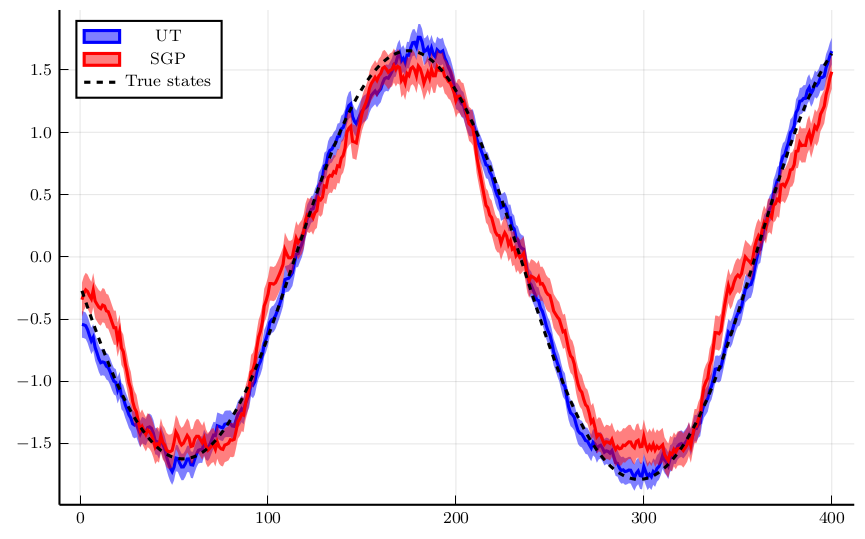

In [41]:
plot(UT_predict_future,ribbon=sqrt.(UT_var_predict_future),
    label="UT",lw=1.5, legend=:topleft, color=:blue)
plot!(getindex.(mean.(predicted_state),1),ribbon = sqrt.(getindex.(var.(predicted_state),1)) , 
        label="SGP",lw=1.5, color=:red)
plot!(getindex.(true_state_test,1),label="True states", ls=:dash,lw=1.5, color=:black)
# xlabel!("t")

In [46]:
savefig("texfiles/pendulum_1stepprediction.svg")

"/Users/nguyenhuuminhhoang/PhD/GaussianProcessNode/texfiles/pendulum_1stepprediction.svg"

In [42]:
rmse_UT_prediction = rmse_score(getindex.(true_state_test,1), UT_predict_future)
rmse_GPnode_prediction = rmse_score(getindex.(true_state_test,1), getindex.(mean.(predicted_state),1))
println("The rmse of SGP node: $rmse_GPnode_prediction")
println("The rmse of UT: $rmse_UT_prediction")

The rmse of SGP node: 0.2140368985449378
The rmse of UT: 0.07668851542763291


## Optimize hyper-parameters

In [28]:
kernel_gp_param = (θ) -> θ[1]* with_lengthscale(Matern52Kernel(),θ[2]); 
kernelmatrix_param = (θ) -> kernelmatrix(kernel_gp_param(θ),Xu,Xu);
function my_free_energy(θ)
    my_Kuu = kernelmatrix_param(θ)
    my_Kuu_inverse = inv(my_Kuu)
    my_kernel = kernel_gp_param(θ)

    init = @initialization begin
        q(v) = MvNormalMeanCovariance(zeros(size(kron(C,my_Kuu),1)),100*diageye(size(kron(C,my_Kuu),1)))
        q(x) = MvNormalMeanCovariance([1.6,0], 0.1*diageye(2))
        q(W) = Wishart(1e2,diageye(2))
    end
    
    infer_result = infer(
        model = pendulum_GP(Kuu_big = kron(C,my_Kuu), P=P,),
        iterations = 5,
        data = (y = y_train,),
        constraints = gp_constraint,
        initialization = init,
        meta = gpssm_meta(Xu, my_Kuu_inverse,C,my_kernel,GPCache()),
        returnvars = (x = KeepLast(), v = KeepLast(), W = KeepLast(),),
        free_energy = true
    ) 
    return infer_result.free_energy[end]
end

function learn_params(θ,iter)
    lower = [1e-1,1e-1]
    upper = [Inf,Inf]
    res = optimize((x) -> my_free_energy(x),lower,upper,θ,Fminbox(NelderMead()),Optim.Options(iterations = iter))
    return res.minimizer
end

learn_params (generic function with 1 method)

In [30]:
θ_init = [1.,1.]
θ_optimal = learn_params(θ_init,5)

2-element Vector{Float64}:
 0.12976379394531257
 3.439532470703125